# Using Tractor catalog for positions

In [3]:
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.utils import data as data_utils
from astropy.nddata import bitmask

from scipy.ndimage import distance_transform_edt

# version dependencies are currently an issue
import pkg_resources
pkg_resources.require("numpy==1.26.3")
import numpy as np

# import json
# import requests
from dl import authClient as ac, queryClient as qc
import pandas as pd

/Users/vernica/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Image query

In [ ]:
def query_tractor(ra_b, dec_b, dist):
    """Queries the Astro Data Lab for the ra, dec, mag_g, mag_r, mag_i, mag_z of the objects within a square of side length (dist).     
    dist is in degrees
    """
    #Bounds of the square we are querying objects for
    ra_min=ra_b
    ra_max = ra_b + dist
    dec_min=dec_b
    dec_max = dec_b + dist

    query = f"""
    SELECT ra, dec, mag_g,mag_r,mag_i,mag_z
    FROM ls_dr10.tractor_s
    WHERE ra >= ({ra_min}) AND ra < ({ra_max})
    AND dec >= ({dec_min}) AND dec < ({dec_max})
    AND (mag_g<=21 AND mag_g>=16
        OR mag_r<=21 AND mag_r>=16
        OR mag_i<=21 AND mag_i>=16
        OR mag_z<=21 AND mag_z>=16)       
    """
    
    print("Querying the Astro Data Lab...")
    # check if this completes successfuly
    brick_info = qc.query(sql=query, fmt="pandas")
    return brick_info

tractor_df = query_tractor(0, 0, 1.0)
tractor_df

Querying the Astro Data Lab...


,ra,dec,mag_g,mag_r,mag_i,mag_z
0,0.078990,0.013123,20.010588,19.369090,19.176360,19.087679
1,0.078851,0.105726,19.390509,17.943230,16.971571,16.538206
2,0.205316,0.028401,20.625372,20.214240,20.087050,20.045910
3,0.193515,0.067243,20.240402,19.939835,19.864164,19.857294
4,0.208100,0.057905,18.617342,17.705297,17.318098,17.057484
...,...,...,...,...,...,...
12699,0.965541,0.991770,18.387604,17.964900,17.832508,17.799880
12700,0.984671,0.979338,20.796118,19.330091,18.293623,17.862780
12701,0.995618,0.988664,18.641650,17.592907,17.245693,17.078724
12702,0.996237,0.989150,22.271858,21.229586,20.804283,20.547740


In [ ]:
ra = tractor_df['ra']
dec = tractor_df['dec']
dim = 3600*4

def mask_radius(mag_g, fov_radius=20):
    return (fov_radius/3600) + 1630./3600. * 1.396**(-mag_g)

rad = mask_radius(tractor_df['mag_g'])
rad_pix = np.ceil(rad*dim).astype(int)

min_ra = ra - rad
max_ra = ra + rad

0       0.072863
1       0.072593
2       0.199295
3       0.187430
4       0.201635
          ...   
3045    0.985739
3046    0.949861
3047    0.959004
3048    0.978676
3049    0.989161
Length: 3050, dtype: float64

Positions and masking radius for stars with magnitudes <16 are listed in the `mask_data_[N].npz` files. Each index is a different range of DEC:

| index | (DEC1, DEC2) |
| ----- | ----------- | 
| 0 | (-90, -66) |
| 1 | (-66, -42) |
| 2 | (-42, -18) |
| 3 | (-18, 6) |
| 4 | (6, 30) |

In [7]:
def load_mask_data(index=0, load_all=False):
    """Load a desired mask data file by index, or just download all five. 
    Returns a pandas Dataframe with columns 'ra', 'dec', 'radius'
    """
    
    # load all
    if load_all:
        all_masks = []
        for i in range(5):
            
            with np.load(f"mask_data_{i}.npz", mmap_mode='r') as mask_data:
                mask_array = mask_data['arr_0']
                mask_array_byteswap = mask_array.byteswap().newbyteorder()
                masked_stars = pd.DataFrame(mask_array_byteswap)
                all_masks.append(masked_stars)
        return pd.concat(all_masks, ignore_index=True)

    # load single index
    with np.load(f"mask_data_{index}.npz", mmap_mode='r') as mask_data:
        mask_array = mask_data['arr_0']
        mask_array_byteswap = mask_array.byteswap().newbyteorder()
        masked_stars = pd.DataFrame(mask_array_byteswap)

    return masked_stars
        
masked_stars = load_mask_data(load_all=True)
    

In [9]:
# sort by radius
radius_sorted = masked_stars.sort_values(by='radius', ascending=False)
radius_sorted = radius_sorted.reset_index(drop=True)
# radius_sorted.query('radius > 0.2 and overlap==True')

# apply a buffer of a minimum exclusion zone radius to all masks (arcsec)
exclusion_minimum = 20
radius_sorted['radius'] = radius_sorted['radius'] + (20 / 3600)

# convert to pixel radius
dim = 3600 * 4
radius_sorted['rad_pix'] = np.ceil(radius_sorted['radius']*dim).astype(int)

# find max and min ra/dec corresponding to the mask of star
radius_sorted['max_ra'] = radius_sorted['ra'] + radius_sorted['radius']
radius_sorted['min_ra'] = radius_sorted['ra'] - radius_sorted['radius']
radius_sorted['max_dec'] = radius_sorted['dec'] + radius_sorted['radius']
radius_sorted['min_dec'] = radius_sorted['dec'] - radius_sorted['radius']

# separate array for radii that go above 1-degree integer RA/DEC bounds
expression = '(max_ra > ceil(ra)) | (min_ra < floor(ra)) | (max_dec > ceil(dec)) | (min_dec < floor(dec))'

# boolean in same array to convey the same info
radius_sorted['overlap'] = radius_sorted.eval(expression)

radius_sorted

,ra,dec,radius,rad_pix,max_ra,min_ra,max_dec,min_dec,overlap
0,95.987878,-52.695718,0.571576,8231,96.559453,95.416302,-52.124142,-53.267294,True
1,213.918115,19.187273,0.434656,6260,214.352771,213.483459,19.621929,18.752617,True
2,78.634464,-8.201639,0.417979,6019,79.052443,78.216484,-7.783660,-8.619618,True
3,258.661928,14.390257,0.398903,5745,259.060831,258.263025,14.789160,13.991354,True
4,114.827242,5.227508,0.393789,5671,115.221031,114.433453,5.621297,4.833719,True
...,...,...,...,...,...,...,...,...,...
19204371,90.263031,-37.071822,0.005556,80,90.268586,90.257475,-37.066267,-37.077378,False
19204372,284.899412,-46.645754,0.005556,80,284.904967,284.893856,-46.640198,-46.651309,False
19204373,20.076793,21.372984,0.005556,80,20.082348,20.071237,21.378540,21.367429,False
19204374,56.351719,-27.862083,0.005556,80,56.357275,56.346163,-27.856527,-27.867638,False


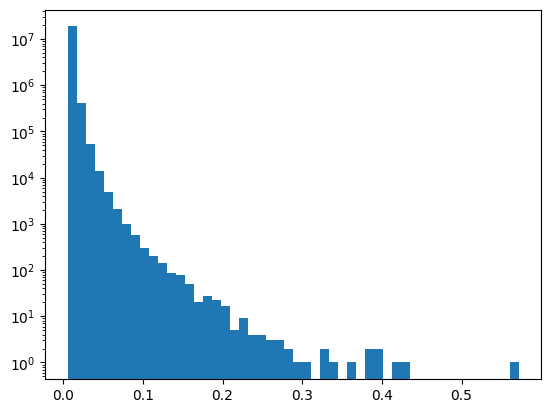

In [11]:
# histogram of mask radii
fig, ax = plt.subplots()
ax.hist(radius_sorted['radius'], bins=50)
# ax.vlines(20/3600, ymin=0, ymax=1e6, color='r')
ax.set(yscale='log')
plt.show()

In [12]:
def concat_masks(ra,dec,dist=1):
    degree_masks = radius_sorted.query(f'({ra} < ra < {ra+dist}) & ({dec} < dec < {dec+dist})')
    return(degree_masks)
concat_masks(0,0)

,ra,dec,radius,rad_pix,max_ra,min_ra,max_dec,min_dec,overlap
22318,0.163102,0.222924,0.040128,578,0.203230,0.122974,0.263052,0.182796,False
74530,0.364999,0.301582,0.028498,411,0.393497,0.336501,0.330081,0.273084,False
82375,0.527190,0.415351,0.027710,400,0.554900,0.499480,0.443061,0.387641,False
90830,0.115664,0.205260,0.026964,389,0.142628,0.088700,0.232225,0.178296,False
96981,0.491148,0.128361,0.026473,382,0.517621,0.464675,0.154834,0.101889,False
...,...,...,...,...,...,...,...,...,...
18881109,0.056604,0.990996,0.007751,112,0.064356,0.048853,0.998748,0.983245,False
18961643,0.248616,0.316120,0.007746,112,0.256363,0.240870,0.323866,0.308373,False
19000328,0.451883,0.048767,0.007744,112,0.459627,0.444139,0.056511,0.041023,False
19114119,0.303642,0.685747,0.007737,112,0.311379,0.295904,0.693484,0.678010,False


Finding everything within the square RA=(3, 4) and DEC=(-4, -3)
min ra: 2.984696008407812
min dec: -4.008426710894652
max ra: 4.009241896688543
max dec: -2.958397070947133


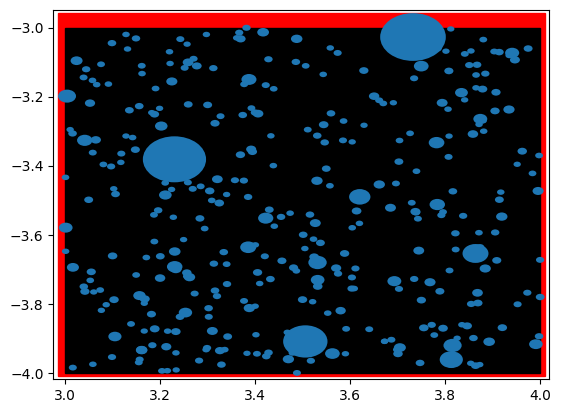

(2.984696008407812, -4.008426710894652, 4.009241896688543, -2.958397070947133)

In [13]:

def find_overlapping_extent(ra, dec):
    # grab everything in a 1 degree square
    print(f"Finding everything within the square RA=({ra}, {ra+1}) and DEC=({dec}, {dec+1})")
    
    degree_masks = radius_sorted.query(f'({ra} < ra < {ra+1}) & ({dec} < dec < {dec+1})')

    min_ra = degree_masks['min_ra'].min()
    min_dec = degree_masks['min_dec'].min()
    max_ra = degree_masks['max_ra'].max()
    max_dec = degree_masks['max_dec'].max()

    print(f"min ra: {min_ra}")
    print(f"min dec: {min_dec}")
    print(f"max ra: {max_ra}")
    print(f"max dec: {max_dec}")

    fig, ax = plt.subplots()
    r = plt.Rectangle(xy=(ra, dec), width=1, height=1, hatch='/', color='k')
    r2 = plt.Rectangle(xy=(min_ra, min_dec), width=max_ra-min_ra, height=max_dec-min_dec, color='r')
    ax.add_patch(r2)
    ax.add_patch(r)
    for ra, dec, rad in zip (degree_masks['ra'], degree_masks['dec'], degree_masks['radius']):
        c = plt.Circle(xy=(ra, dec), radius=(rad))
        ax.add_patch(c)
        
    ax.set(xlim=(min_ra-0.01, max_ra+0.01), ylim=(min_dec-0.01, max_dec+0.01))
    plt.show()
    
    return min_ra, min_dec, max_ra, max_dec

find_overlapping_extent(3, -4)

## Segmentation map

Start with OG seg map, without bitmask stuff yet

In [14]:
# creating seg map by pixels

dim = 3600*4
array = np.zeros((dim, dim), dtype=int)
# print(np.round(ra*dim).astype(int) - 1) 
ra_pix = np.round(ra*dim).astype(int) - 1
dec_pix = np.round(dec*dim).astype(int) - 1
# ra_pix

In [15]:
print(np.min(dec_pix))

-160723
